<a href="https://colab.research.google.com/github/lazysjb/camelyon16/blob/master/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling 

## Get Moduels and Data

In [0]:
# import libraries
from google.colab import drive
import os
import zipfile
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# mount drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# working directory
path = 'gdrive/My Drive/STUDY/Columbia/Term 2/Applied Deep Learning/Project/Final Training Data/shared_files'
os.listdir(path)


['train_val_test_split.json',
 'tumor_img_meta_info.json',
 'zoom_5_60_60_partition.zip',
 'zoom_5_60_60_partition']

In [0]:
# unzip data folders to root dir
zf = zipfile.ZipFile(os.path.join(path, 'zoom_5_60_60_partition.zip'))
zf.extractall()

## Preprocess Data

In [6]:
!ls zoom_5_60_60_partition/train

mask  slide


In [7]:
# get metadata
df_meta_greyscale = pd.read_json('zoom_5_60_60_partition/meta/all_info_0.4_grayscale_tol.json')
df_meta_greyscale.head()

,file_name,img_id,include,label,non_gray_ratio,type
0,tumor_slide_001_split_25_26.png,1,0,0,0.000000,val
1,tumor_slide_001_split_25_32.png,1,0,0,0.000000,val
2,tumor_slide_001_split_77_12.png,1,0,0,0.043333,val
3,tumor_slide_001_split_31_47.png,1,0,0,0.000556,val
4,tumor_slide_001_split_79_17.png,1,0,0,0.031389,val


In [0]:
# cast target as string (keras needs strings)
%%capture
df_meta_greyscale.loc[:, 'label'] = df_meta_greyscale.label.astype('str')

In [26]:
# get patches with sufficient tissue
df_train = df_meta_greyscale.loc[(df_meta_greyscale.include == 1) & (df_meta_greyscale['type'] == 'train'),:]

df_train.head()

,file_name,img_id,include,label,non_gray_ratio,type
11567,tumor_slide_005_split_90_25.png,5,1,0,0.476667,train
11582,tumor_slide_005_split_87_15.png,5,1,0,0.966667,train
11608,tumor_slide_005_split_89_10.png,5,1,0,0.805278,train
11618,tumor_slide_005_split_89_11.png,5,1,0,0.978889,train
11627,tumor_slide_005_split_80_21.png,5,1,0,0.822222,train


In [28]:
# get patches with sufficient tissue
df_val = df_meta_greyscale.loc[(df_meta_greyscale.include == 1) & (df_meta_greyscale['type'] == 'val'),:]

df_val.head()

,file_name,img_id,include,label,non_gray_ratio,type
5,tumor_slide_001_split_70_33.png,1,1,0,0.975833,val
9,tumor_slide_001_split_70_27.png,1,1,0,0.985556,val
28,tumor_slide_001_split_0_46.png,1,1,0,0.666944,val
45,tumor_slide_001_split_60_22.png,1,1,0,0.960278,val
52,tumor_slide_001_split_41_13.png,1,1,0,0.997500,val


In [29]:
# get patches with sufficient tissue
df_test = df_meta_greyscale.loc[(df_meta_greyscale.include == 1) & (df_meta_greyscale['type'] == 'test'),:]

df_test.head()

,file_name,img_id,include,label,non_gray_ratio,type
5777,tumor_slide_002_split_52_16.png,2,1,0,0.422500,test
5783,tumor_slide_002_split_55_23.png,2,1,0,0.912500,test
5803,tumor_slide_002_split_63_36.png,2,1,0,0.886389,test
5854,tumor_slide_002_split_61_33.png,2,1,0,0.938333,test
5903,tumor_slide_002_split_50_13.png,2,1,0,0.949444,test


In [11]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range=180,
                                                         horizontal_flip=True)
# read data from the train directory
train_generator = datagen.flow_from_dataframe(dataframe = df_train, 
                                              directory = 'zoom_5_60_60_partition/train/slide',
                                              x_col = 'file_name', 
                                              y_col='label',
                                              class_mode='binary', 
                                              target_size=(60,60), 
                                              batch_size=32)



Found 4662 images belonging to 2 classes.


In [30]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# read data from the train directory
val_generator = datagen.flow_from_dataframe(dataframe = df_val, 
                                              directory = 'zoom_5_60_60_partition/val/slide',
                                              x_col = 'file_name', 
                                              y_col='label',
                                              class_mode='binary', 
                                              target_size=(60,60), 
                                              batch_size=32)



Found 1283 images belonging to 2 classes.


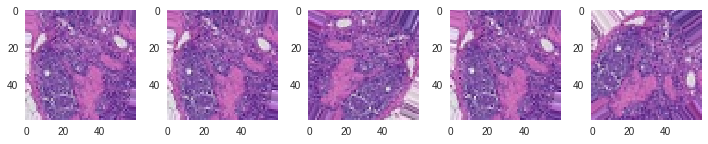

In [12]:
# plot augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Train Model

In [31]:
# specify model architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# print model architecture
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 58, 58, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 128)         147584    
__________

In [33]:
EPOCHS = 10

model.fit_generator(train_generator,
                   epochs = EPOCHS,
                   validation_data = val_generator)

Epoch 1/10
146/146 [==============================] - 11s 77ms/step - loss: 0.4371 - acc: 0.8449 - val_loss: 0.4584 - val_acc: 0.8807
Epoch 2/10
146/146 [==============================] - 11s 74ms/step - loss: 0.3362 - acc: 0.8548 - val_loss: 0.4188 - val_acc: 0.8807
Epoch 3/10
146/146 [==============================] - 11s 74ms/step - loss: 0.3264 - acc: 0.8846 - val_loss: 0.3454 - val_acc: 0.8807
Epoch 4/10
146/146 [==============================] - 11s 75ms/step - loss: 0.3245 - acc: 0.8891 - val_loss: 0.3959 - val_acc: 0.8807
Epoch 5/10
146/146 [==============================] - 11s 76ms/step - loss: 0.3063 - acc: 0.8979 - val_loss: 0.3842 - val_acc: 0.8807
Epoch 6/10
146/146 [==============================] - 11s 76ms/step - loss: 0.3015 - acc: 0.8988 - val_loss: 0.3417 - val_acc: 0.8807
Epoch 7/10
146/146 [==============================] - 11s 75ms/step - loss: 0.2851 - acc: 0.9030 - val_loss: 0.3937 - val_acc: 0.8807
Epoch 8/10
146/146 [==============================] - 11s 74ms